In [1]:
require 'loadcaffe'
require 'image'

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 

-- prototxt_name = '/Users/yusheng/Workspace/deep-visualization-toolbox/models/caffenet-yos/caffenet-yos-deploy.prototxt'
-- binary_name = '/Users/yusheng/Workspace/deep-visualization-toolbox/models/caffenet-yos/caffenet-yos-weights'

prototxt_name = '/usr/local/data/CaffeZoo/caffenet-yos/deploy.prototxt'
binary_name = '/usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights'


print '==> Loading network'

net = loadcaffe.load(prototxt_name, binary_name, 'cudnn')

-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

net:forward(I:cuda())
conv1_fm = net:get(1).output

==> Loading network	


Successfully loaded /usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights


MODULE data UNDEFINED


conv1: 96 3 11 11
conv2: 256 48 5 5


conv3: 384 256 3 3


conv4: 384 192 3 3


conv5: 256 192 3 3


fc6: 1 1 9216 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


==> Loading image and imagenet mean	


==> Preprocessing	


In [2]:
require 'cudnn'
local SpatialUnPooling, parent = torch.class('cudnn.SpatialUnPooling', 'cudnn.SpatialMaxPooling')


function SpatialUnPooling:__init( poolLayer, conv_fm )
    assert( torch.typename(poolLayer) == 'cudnn.SpatialMaxPooling', 'Input should be cudnn.SpatialMaxPooling()')
    parent.__init(self, poolLayer.kW, poolLayer.kH, poolLayer.dW, poolLayer.dH, poolLayer.padW, poolLayer.padH )
    self:reset() 
    self.reconstruction_size = conv_fm:size(2)
    self.switches = self:creatSwitchesTable(conv_fm:cuda())
    cutorch.synchronize()
end

function SpatialUnPooling:creatSwitchesTable(conv_fm)
    local stride_size = self.dW
    local kernel_size = self.kW
    local switches={}
    
    conv_fm = nn.SpatialZeroPadding(0, 0, 0, 0 ):forward(conv_fm:cuda())
    for i=1,conv_fm:size(1) do
        local x=1
        local counter =1
        switches[i]={}
        while x<=conv_fm:size(2) do
            local y=1
            while y<=conv_fm:size(3) do
                local x_ub = x+kernel_size-1
                local y_ub = y+kernel_size-1
                if x_ub > conv_fm:size(2) then
                    x_ub = conv_fm:size(2)
                end

                if y_ub > conv_fm:size(3) then
                    y_ub = conv_fm:size(3)
                end          

                local max_kernel = conv_fm[{{i},{x,x_ub},{y,y_ub}}]            
                max_col,idx_col=torch.max(max_kernel[1],2)
                max_val,idx_row=torch.max(max_col,1)
                switches[i][counter] = { max_row=x-1+idx_row[1][1], 
                                           max_col=y-1+idx_col[idx_row[1][1]][1] }
                counter = counter + 1    
                y=y+stride_size
            end

            x=x+stride_size
        end
    end   
    
    return switches
end

function SpatialUnPooling:updateOutput( pool_fm )
    local unpool_fm = torch.CudaTensor( pool_fm:size(1), self.reconstruction_size , self.reconstruction_size ):zero():cuda()
    
    for i=1,pool_fm:size(1) do
        local row=1
        local col=1
        for j in pairs(self.switches[i]) do
            unpool_fm[i][self.switches[i][j].max_row][self.switches[i][j].max_col] = pool_fm[i][row][col]
            if col+1<=pool_fm:size(2) then
                col = col +1
            else
                col = 1
                row = row + 1
            end
        end
    end  
    
    return unpool_fm
end 


In [3]:
timer = torch.Timer()
unpool1 = cudnn.SpatialUnPooling(net:get(3), conv1_fm  )
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')

==> Time elapsed: 0.85541105270386 seconds	


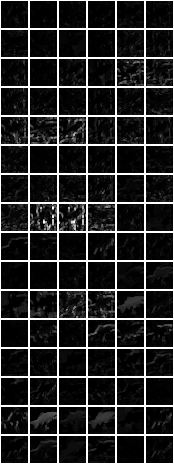

==> Time elapsed: 0.95311403274536 seconds	


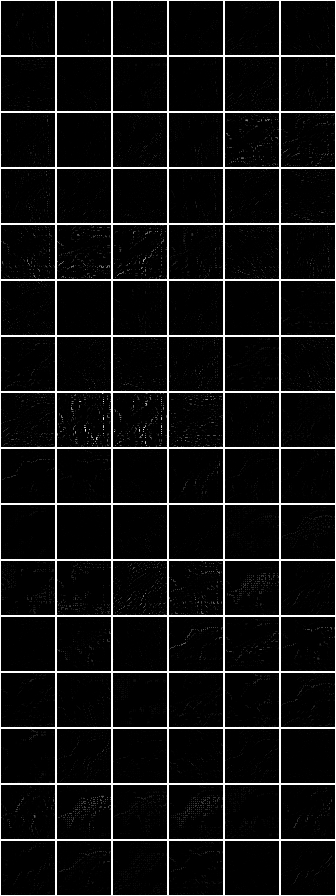

In [8]:
pool1_fm = net:get(3).output
itorch.image(pool1_fm)
timer = torch.Timer()
unpool_fm = unpool1:forward(pool1_fm)
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')
itorch.image(unpool_fm)